# Part II: Experiments

In [270]:
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import norm

In [28]:
def buildTree(S, vol, T, N):
    
    dt = T / N
    
    matrix = np.zeros((N+1, N+1))
    
    u = np.exp(vol * np.sqrt(T/N))
    d = np.exp(-vol * np.sqrt(T/N))
    
    # Iterate over the lower triangle
    for i in np.arange(N+1):
        for j in np.arange(i + 1):
            matrix[i,j] = S*(u**j)*(d**(i-j))

    return matrix

In [27]:
def valueOptionMatrix(tree, vol, T, r, K, option="call"):
    
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    dt = T/rows
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d) / (u - d)
    assert 0<d<np.exp(r*dt)<u,  "the model doesn't work with these parameters"  
    
    option_matrix = np.zeros((rows, columns))
    
    # Walk backwards, we start in last row of the matrix
    # Add the payoff function in the last row
    for column in np.arange(columns):
        S = tree[rows - 1, column]
        option_matrix[rows - 1, column] =  S - K if S-K > 0 else 0
        if option == "put":
            option_matrix[rows - 1, column] =  K-S if K-S > 0 else 0
    
    # For a l l o t h e r rows , we need t o combine from p r e v i o u s rows
    # We walk backwards , from t h e l a s t row t o t h e f i r s t row
    for row in np.arange(rows - 1)[::-1]:
        for column in np.arange(row + 1):
            down = option_matrix[row + 1, column]
            up = option_matrix[row+1, column+1]
            option_matrix[row, column] = (up*p+down*(1-p)) * np.exp(-r*dt)
                
    return option_matrix

## 1. Binomial tree model for option pricing

In [314]:
'''
Example from appendix
'''

r = 0.06
vol = 0.20
S = 100
T = 1
N = 50

tree = buildTree(S, vol, T, N)
valueoption = valueOptionMatrix(tree, vol, T, r, 99)

In [193]:
print(f"Option should be priced at: {valueoption[0][0]}")

Option should be priced at: 11.533479908894494


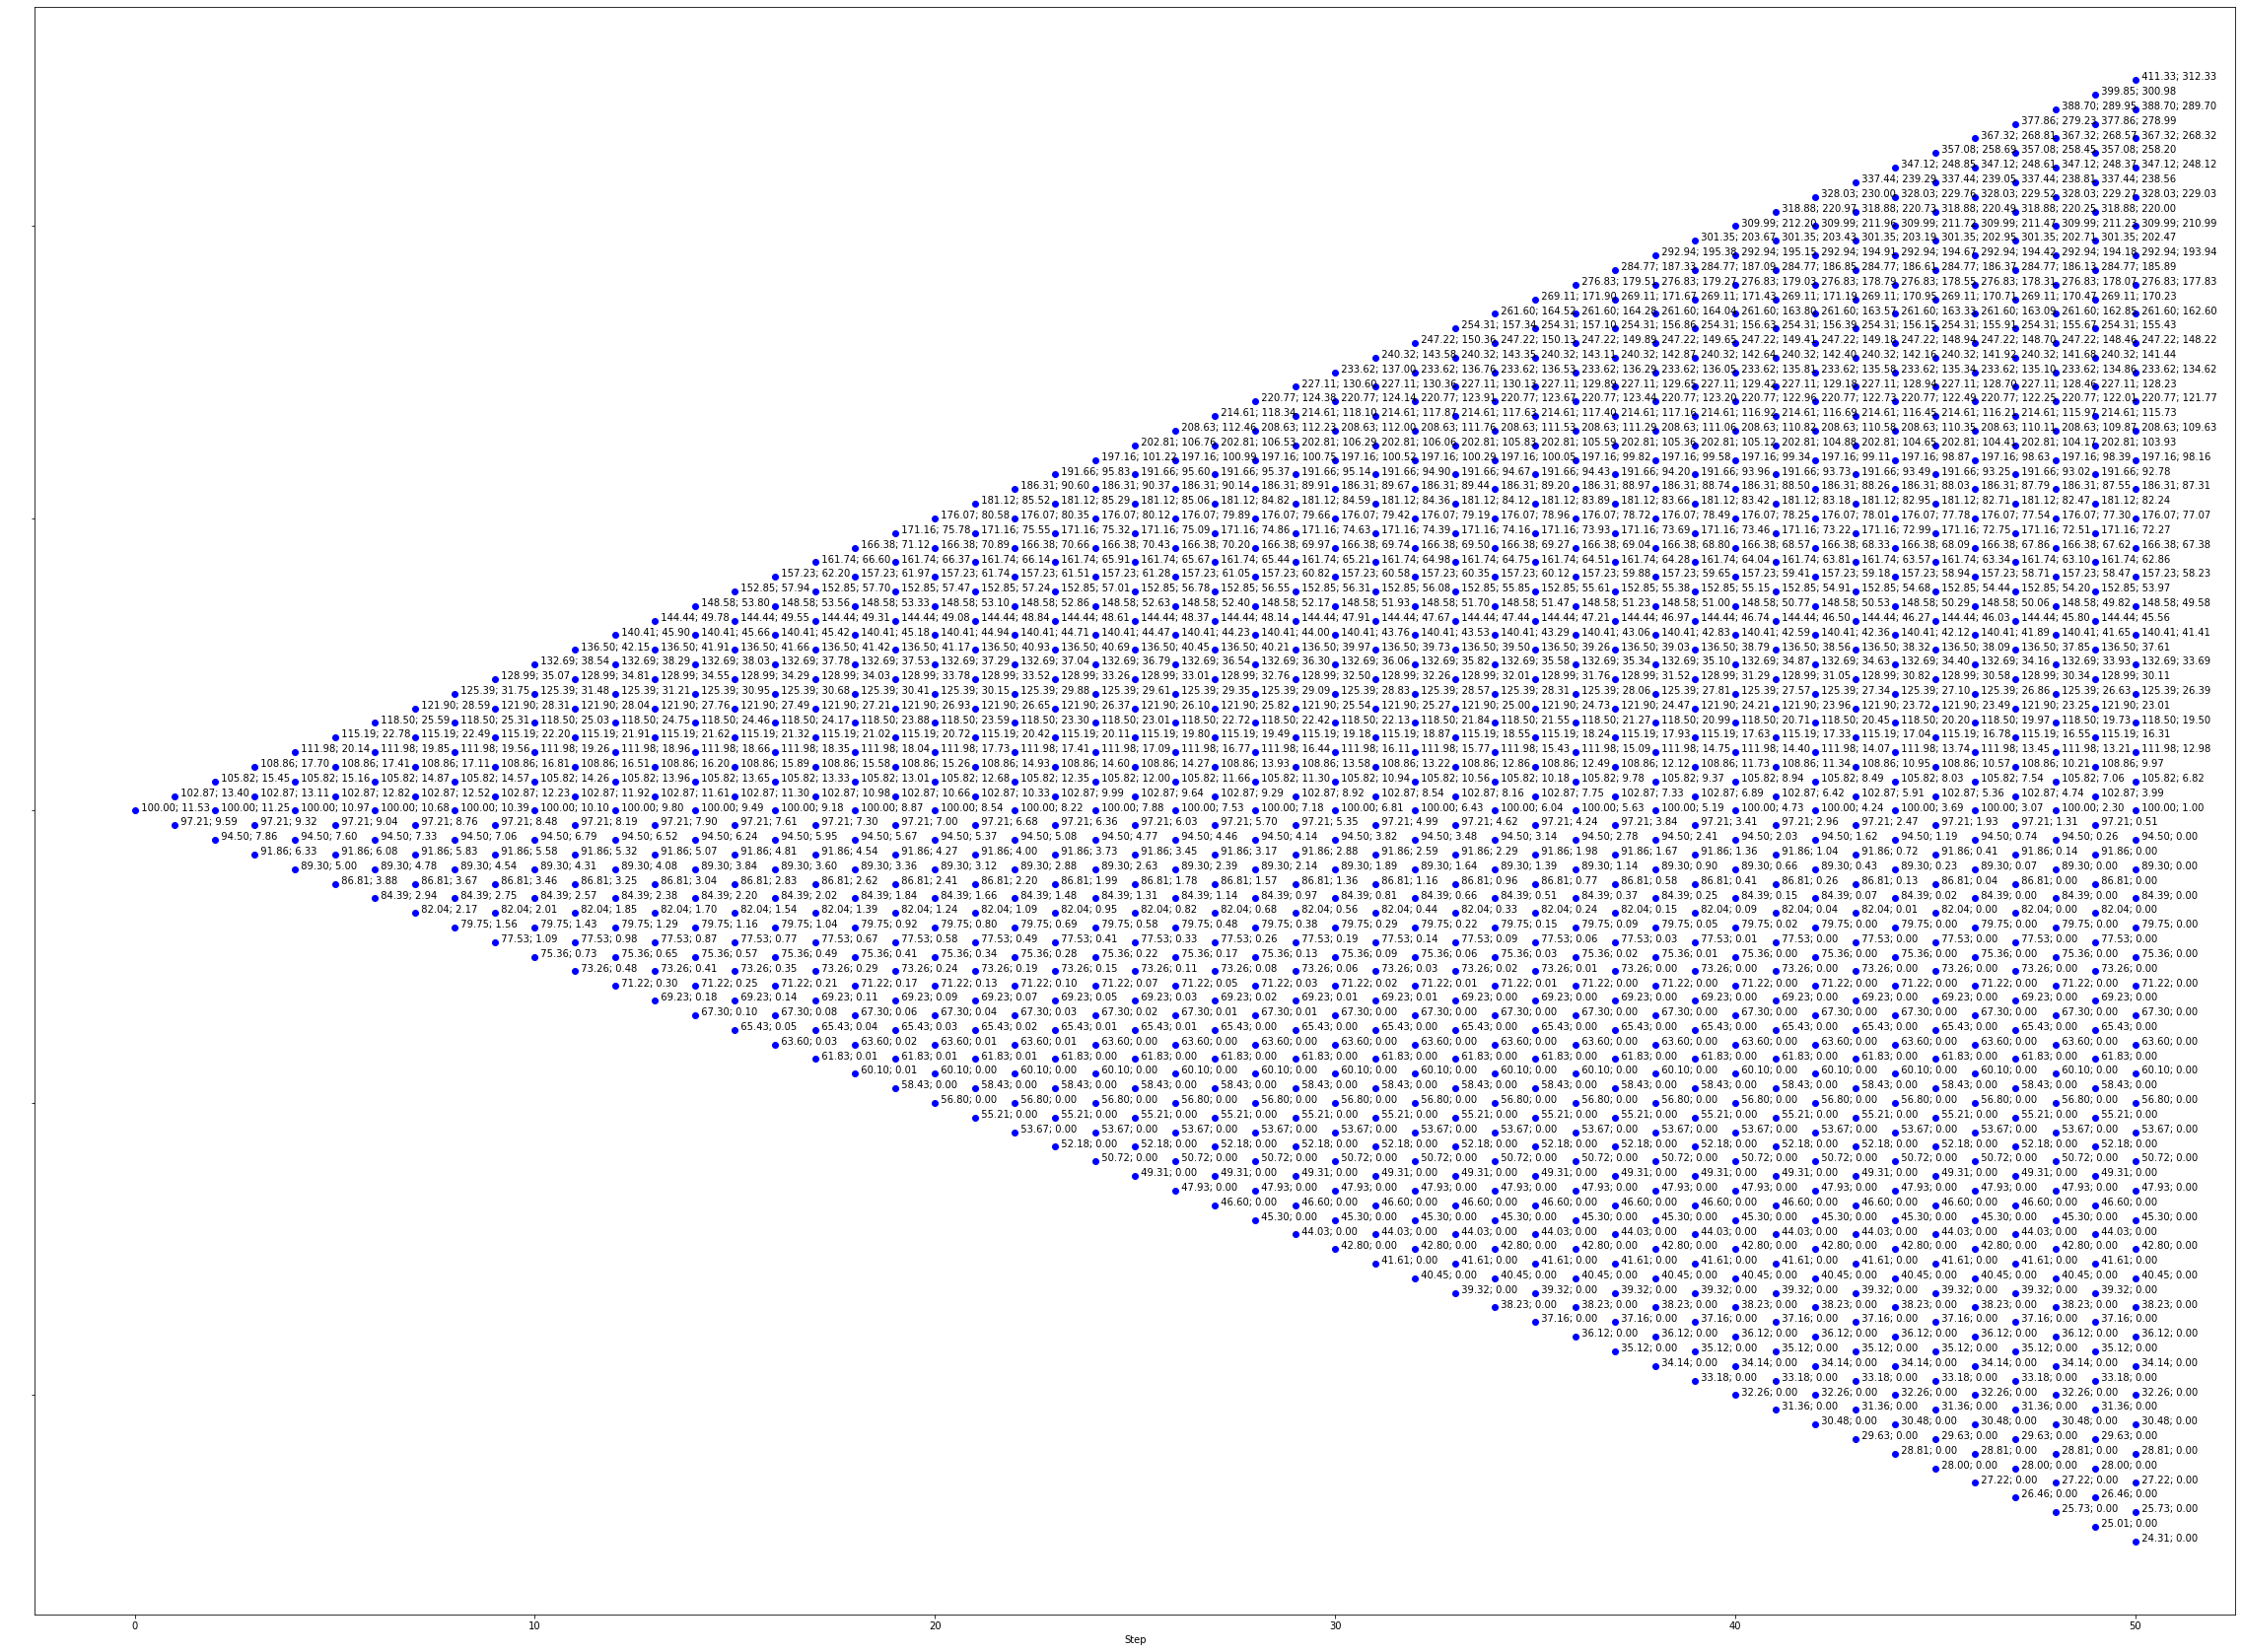

In [191]:
'''
Draw Binomial Tree
'''

yy = [[0],]
x = np.linspace(0, N, N+1)

for i in range(1,N+1):
    yy.append(np.linspace(-i, i, i+1))


plt.figure(figsize = (40, 30))

for i in range(len(yy)):
    
    if type(yy[i]) == int:
        plt.plot(x[i], yy[i] , 'ro')
    else:
        for j in range(len(yy[i])):
            plt.plot(x[i], yy[i][j], 'bo' )
            plt.annotate(f"  {tree[i][j]:.2f}; {valueoption[i][j]:.2f}", (x[i] , yy[i][j]))

plt.xlabel('Step')
plt.yticks(color='w')
plt.show()

## 2. Black-Scholes compared with Binomial values

In [322]:
""" 
Black Scholes Model for European Call
"""

def Black_Scholes_Call(S, K, r, vol, tau):
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)

    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    #print('Black Scholes European Call Option Value: ', V)
    #print('Black Scholes European Call Delta: ', d1)
    
    return V, norm.cdf(d1)

In [333]:
r = 0.06
vol = 0.2
S = 100
T = 1
K = 99
N1 = 50
N2 = 100
N3 = 500

t = 0
tau = T - t

In [334]:
Black_Scholes_Call(S, K, r, vol, tau)

(11.544280227051097, 0.6737355117348961)

In [335]:
binomial_50 = []
binomial_100 = []
binomial_200 = []
blacksholes = []

x = np.linspace(0.01, 5, 30)

for v in x:
    
    blacksholes.append(Black_Scholes_Call(S, K, r, v, tau)[0])
    
    # 50
    tree = buildTree(S, v, T, N1)    
    europe_call = valueOptionMatrix(tree, v, T, r, K)
    binomial_50.append(europe_call[0][0])
    
    # 100
    tree = buildTree(S, v, T, N2)    
    europe_call = valueOptionMatrix(tree, v, T, r, K)
    binomial_100.append(europe_call[0][0])
    
    # 200
    tree = buildTree(S, v, T, N3)    
    europe_call = valueOptionMatrix(tree, v, T, r, K)
    binomial_200.append(europe_call[0][0])
    

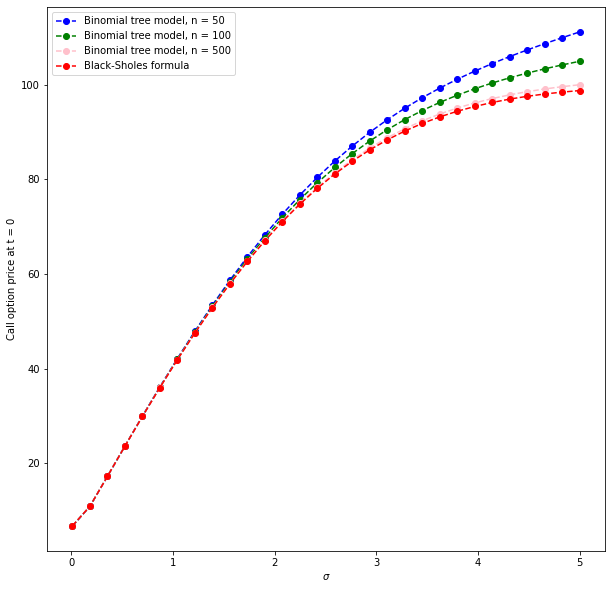

In [337]:
plt.figure(figsize = (10,10))
plt.plot(x , binomial_50, linestyle='--', marker='o', color='b', label = 'Binomial tree model, n = 50')
plt.plot(x , binomial_100, linestyle='--', marker='o', color='g', label = 'Binomial tree model, n = 100')
plt.plot(x , binomial_200, linestyle='--', marker='o', color='pink', label = 'Binomial tree model, n = 500')

plt.plot(x , blacksholes, linestyle='--', marker='o', color='r', label = 'Black-Sholes formula')

plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel("Call option price at t = 0")
plt.show()

In [317]:
r = 0.06
vol = 0.2
S = 100
T = 1
K = 99
N = 200

t = 0
tau = T - t

In [318]:
binomial = []
blacksholes = []

x = np.linspace(0.01, 5, 30)

for v in x:
    
    tree = buildTree(S, v, T, N)
    europe_call = valueOptionMatrix(tree, v, T, r, K)
    
    binomial.append(europe_call[0][0])
    blacksholes.append(Black_Scholes_Call(S, K, r, v, tau)[0])

Black Scholes European Call Option Value:  6.765311175159553
Black Scholes European Call Option Value:  10.90150110158578
Black Scholes European Call Option Value:  17.22371857621875
Black Scholes European Call Option Value:  23.606833900253804
Black Scholes European Call Option Value:  29.887820772687512
Black Scholes European Call Option Value:  35.999189695994204
Black Scholes European Call Option Value:  41.893976682618266
Black Scholes European Call Option Value:  47.534751908700564
Black Scholes European Call Option Value:  52.89114930716077
Black Scholes European Call Option Value:  57.939213634083764
Black Scholes European Call Option Value:  62.661176979495124
Black Scholes European Call Option Value:  67.04528327635047
Black Scholes European Call Option Value:  71.08554134533699
Black Scholes European Call Option Value:  74.78137278224408
Black Scholes European Call Option Value:  78.137154741169
Black Scholes European Call Option Value:  81.16167286503885
Black Scholes Europ

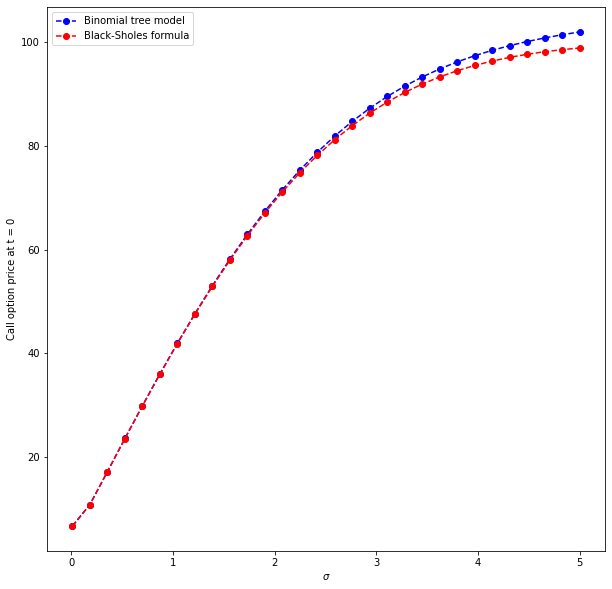

In [319]:
plt.figure(figsize = (10,10))
plt.plot(x , binomial, linestyle='--', marker='o', color='b', label = 'Binomial tree model')
plt.plot(x , blacksholes, linestyle='--', marker='o', color='r', label = 'Black-Sholes formula')

plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel("Call option price at t = 0")
plt.show()

## 3. Convergence

In [38]:
'''
Study Convergence
'''
def run_sample(S, vol, T, N, r, K):
    tree = buildTree(S, vol, T, N)
    return valueOptionMatrix(tree, vol, T, r, K)[0][0]

In [349]:
r = 0.06
vol = 0.2
S = 100
T = 1
K = 99
t = 0
tau = T - t

In [366]:
xdata = np.arange(10,1000,5)
bs = [Black_Scholes_Call(S, K, r, vol, tau)[0] for i in range(len(xdata))]

In [364]:
ans = Parallel(n_jobs=12)(delayed(run_sample)(S=S, vol=vol, T=T, N = i, r=r, K=K)
                                      for i in xdata)


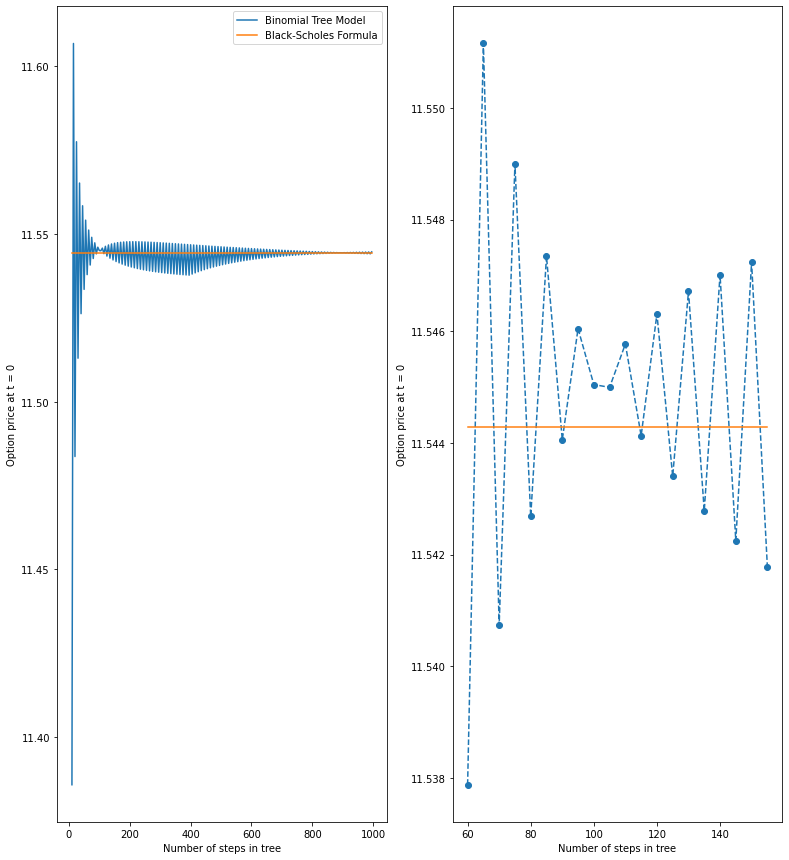

In [376]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,15))

axes[0].plot(xdata, ans, label = 'Binomial Tree Model')
axes[0].plot(xdata, bs, label = 'Black-Scholes Formula')

axes[0].set_ylabel("Option price at t = 0")
axes[0].set_xlabel("Number of steps in tree")
axes[0].legend()

axes[1].plot(np.arange(10,1000,5)[10:30], ans[10:30], linestyle='--', marker='o')
axes[1].plot(xdata[10:30], bs[10:30])
axes[1].set_ylabel("Option price at t = 0")
axes[1].set_xlabel("Number of steps in tree")

plt.show()

## 4. Hedge parameter

In [303]:
"""
Obtain Delta parameter at t=0
"""
def getDelta(S, vol, T, N, r, K):
    """
    Formula to calculate delta
    """
    tree = buildTree(S, vol, T, N)
    option_prices = valueOptionMatrix(tree, vol, T, r, K)

    dt = T / N
    fu = option_prices[1][1]
    fd = option_prices[1][0]
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    S0 = 100
    
    return (fu -fd) / (S0*(u - d))

In [306]:
""" 
Black Scholes Model for European Call
"""

def Black_Scholes_Call(S, K, r, vol, tau):
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)

    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    #print('Black Scholes European Call Option Value: ', V)
    #print('Black Scholes European Call Delta: ', d1)
    
    return V, norm.cdf(d1)

In [380]:
'''
Shit
'''
r = 0.06
vol = 0.3
S = 100
T = 1
K = 99
N = 50
N2 = 100
N3 = 500

t = 0
tau = T - t

In [381]:
print(getDelta(S, v, T, N, r, K))
print(Black_Scholes_Call(S, K, r, v, tau)[1])

1.1165194761556971
0.9940316486776197


In [382]:
binomial_hedge_50 = []
binomial_hedge_100 = []
binomial_hedge_500 = []
blacksholes_hedge = []

x = np.linspace(0.01, 5, 30)

for v in x:   
    binomial_hedge_50.append(getDelta(S, v, T, N, r, K))
    binomial_hedge_100.append(getDelta(S, v, T, N2, r, K))
    binomial_hedge_500.append(getDelta(S, v, T, N3, r, K))
    blacksholes_hedge.append(Black_Scholes_Call(S, K, r, v, tau)[1])

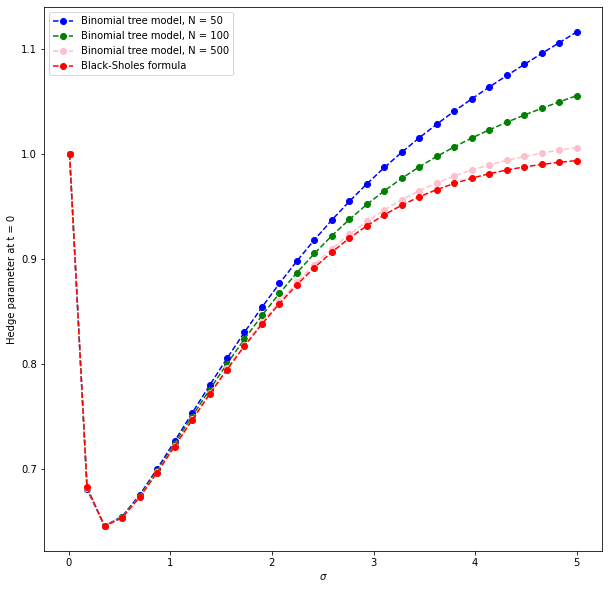

In [384]:
plt.figure(figsize = (10,10))
plt.plot(x , binomial_hedge_50, linestyle='--', marker='o', color='b', label = 'Binomial tree model, N = 50')
plt.plot(x , binomial_hedge_100, linestyle='--', marker='o', color='g', label = 'Binomial tree model, N = 100')
plt.plot(x , binomial_hedge_500, linestyle='--', marker='o', color='pink', label = 'Binomial tree model, N = 500')

plt.plot(x , blacksholes_hedge, linestyle='--', marker='o', color='r', label = 'Black-Sholes formula')

plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel("Hedge parameter at t = 0")
plt.show()

## 5. American compared with European Options

In [194]:
"""
American option
"""
def valueOptionMatrixAmerican(tree, vol, T, r, K, option="call"):
    
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    dt = T/rows
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d) / (u - d)
    assert 0<d<np.exp(r*dt)<u, "the model doesn't work with these parameters" 
    option_matrix = np.zeros((rows, columns))
    
    # Walk backwards, we start in last row of the matrix
    # Add the payoff function in the last row
    for column in np.arange(columns):
        S = tree[rows - 1, column]
        option_matrix[rows - 1, column] =  S - K if S-K > 0 else 0
        if option == "put":
            option_matrix[rows - 1, column] =  K-S if K-S > 0 else 0
    
    # For a l l o t h e r rows , we need t o combine from p r e v i o u s rows
    # We walk backwards , from t h e l a s t row t o t h e f i r s t row
    for row in np.arange(rows - 1)[::-1]:
        for column in np.arange(row + 1):
            down = option_matrix[row + 1, column]
            up = option_matrix[row+1, column+1]
            discounted_value = (up*p+down*(1-p)) * np.exp(-r*dt)
            
            S = tree[row, column]
            value_execute = S - K if S-K > 0 else 0
            if option=="put":
                value_execute = K-S if K-S > 0 else 0

            option_matrix[row, column] = value_execute if value_execute>discounted_value else discounted_value
    return option_matrix

In [195]:
"""
European option
"""
def valueOptionMatrix(tree, vol, T, r, K, option="call"):
    
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    dt = T/rows
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d) / (u - d)
    assert 0<d<np.exp(r*dt)<u,  "the model doesn't work with these parameters"  
    
    option_matrix = np.zeros((rows, columns))
    
    # Walk backwards, we start in last row of the matrix
    # Add the payoff function in the last row
    for column in np.arange(columns):
        S = tree[rows - 1, column]
        option_matrix[rows - 1, column] =  S - K if S-K > 0 else 0
        if option == "put":
            option_matrix[rows - 1, column] =  K-S if K-S > 0 else 0
    
    # For a l l o t h e r rows , we need t o combine from p r e v i o u s rows
    # We walk backwards , from t h e l a s t row t o t h e f i r s t row
    for row in np.arange(rows - 1)[::-1]:
        for column in np.arange(row + 1):
            down = option_matrix[row + 1, column]
            up = option_matrix[row+1, column+1]
            option_matrix[row, column] = (up*p+down*(1-p)) * np.exp(-r*dt)
                
    return option_matrix

In [244]:
'''
Initial condtions
'''
r = 0.06
S = 100
T = 1
N = 50
K = 80

In [264]:
eurocall = []
americacall = []
europut = []
americaput = []

x = np.linspace(0.01, 5, 15)

for vol in x:
    
    tree = buildTree(S, vol, T, N)
    europe_call = valueOptionMatrix(tree, vol, T, r, K)
    america_call = valueOptionMatrixAmerican(tree, vol, T, r, K)
    
    europe_put = valueOptionMatrix(tree, vol, T, r, K, "put")
    america_put = valueOptionMatrixAmerican(tree, vol, T, r, K, "put")
    
    eurocall.append(europe_call[0][0])
    americacall.append(america_call[0][0])
    
    europut.append(europe_put[0][0])
    americaput.append(america_put[0][0])

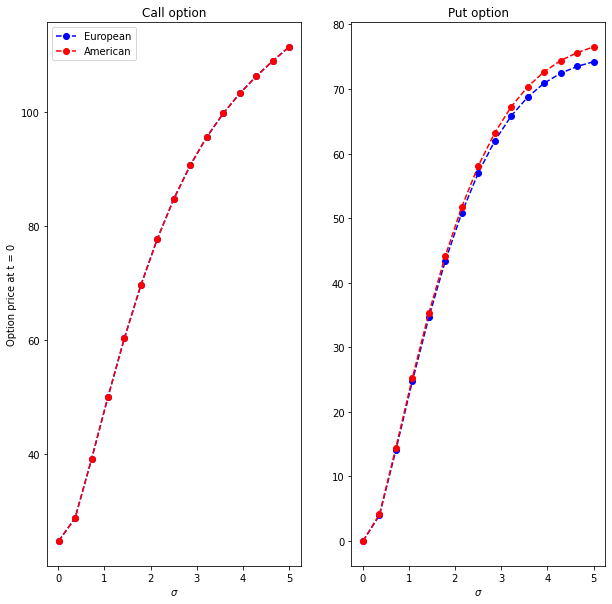

In [265]:
'''
Plot results
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,10))

ax1.plot(x , eurocall, linestyle='--', marker='o', color='b', label = 'European')
ax1.plot(x , americacall, linestyle='--', marker='o', color='r', label = 'American')
ax2.plot(x , europut, linestyle='--', marker='o', color='b')
ax2.plot(x , americaput, linestyle='--', marker='o', color='r')

ax1.set_title('Call option')
ax2.set_title('Put option')
ax1.set_xlabel(r'$\sigma$')
ax2.set_xlabel(r'$\sigma$')
ax1.set_ylabel("Option price at t = 0")

ax1.legend()
plt.show()